# 1. Load Libraries

In [2]:
# Load necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# 2. Load Files

In [4]:
# Loading the dataset

csv_file_path = 'canada_rent.csv'
df = pd.read_csv(csv_file_path, header=None)

# Define column names
df.columns = ['rentfaster_id', 'city', 'province', 'address', 'latitude', 'longitude', 
              'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'link', 
              'furnishing', 'availability_date', 'smoking', 'cats', 'dogs']

# Gather initial information
print(df.head())
print(df.info())

   rentfaster_id     city  province           address    latitude  \
0  rentfaster_id     city  province           address    latitude   
1         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   
2         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   
3         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   
4         468622  Airdrie   Alberta  69 Gateway Dr NE  51.3059622   

     longitude  lease_term       type  price    beds  baths  sq_feet  \
0    longitude  lease_term       type  price    beds  baths  sq_feet   
1  -114.012515   Long Term  Townhouse   2495  2 Beds    2.5     1403   
2  -114.012515   Long Term  Townhouse   2695  3 Beds    2.5     1496   
3  -114.012515   Long Term  Townhouse   2295  2 Beds    2.5     1180   
4  -114.012515   Long Term  Townhouse   2095  2 Beds    2.5     1403   

                                                link   furnishing  \
0                                               link   furnishing   
1  /ab/airdrie

# 3. Data Cleaning and Preprocessing

In [6]:
# 1. Remove the first row since it contains dupliocate headers

df = df[1:].reset_index(drop=True)

In [8]:
# 2. Convert data types, where appropriate

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')
df['beds'] = df['beds'].str.extract(r'(\d+)').astype(float)
df['baths'] = pd.to_numeric(df['baths'], errors='coerce')
df['cats'] = df['cats'].astype(bool)
df['dogs'] = df['dogs'].astype(bool)

In [9]:
# 3. Handle missing values

# Fill missing values for categorical columns
df['address'].fillna('Unknown', inplace=True)
df['lease_term'].fillna('Unknown', inplace=True)
df['furnishing'].fillna('Unknown', inplace=True)
df['smoking'].fillna('Unknown', inplace=True)

# Fill missing values for numeric columns
df['price'].fillna(df['price'].median(), inplace=True)
df['sq_feet'].fillna(df['sq_feet'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)
df['baths'].fillna(df['baths'].median(), inplace=True)

# Fill missing values for 'availability_date'
df['availability_date'].fillna('Unknown', inplace=True)

In [10]:
# 4. Define a function to handle different cases in 'availability_date'

def parse_availability_date(value):
    value_str = str(value)
    if value_str.lower() == 'immediate':
        return pd.Timestamp('2024-01-01')  # Placeholder date
    try:
        return pd.to_datetime(value_str, format='%B %d', errors='coerce')
    except ValueError:
        return pd.NaT

df['availability_date'] = df['availability_date'].apply(parse_availability_date)
df['availability_date'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

In [11]:
# 5. Remove duplicates

df.drop_duplicates(inplace=True)

In [12]:
# 6. Format text data. Strip leading/trailing spaces from string columns

df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [13]:
# 7. Handle outliers

def cap_outliers(series, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower_bound, upper_bound)

df['price'] = cap_outliers(df['price'])
df['sq_feet'] = cap_outliers(df['sq_feet'])

In [14]:
# Final verification and save to a new file

print(df.info())
print(df.describe())

df.to_csv('cleaned_canada_rent.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 19037 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rentfaster_id      19037 non-null  object        
 1   city               19037 non-null  object        
 2   province           19037 non-null  object        
 3   address            19037 non-null  object        
 4   latitude           19037 non-null  float64       
 5   longitude          19037 non-null  float64       
 6   lease_term         19037 non-null  object        
 7   type               19037 non-null  object        
 8   price              19037 non-null  float64       
 9   beds               19037 non-null  float64       
 10  baths              19037 non-null  float64       
 11  sq_feet            19037 non-null  float64       
 12  link               19037 non-null  object        
 13  furnishing         19037 non-null  object        
 14  availabilit

In [15]:
# No missing values, all columns have non-null values
# Data types have been appropriately converted
# Outlier extreme values in price and sq_feet have been capped

# 4. Exploratory Data Analysis (EDA)

In [17]:
# 1. Display the first few rows of the DataFrame

print(df.head())

  rentfaster_id     city province           address   latitude   longitude  \
0        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
1        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
2        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
3        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
6        468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   

  lease_term       type   price  beds  baths  sq_feet  \
0  Long Term  Townhouse  2495.0   2.0    2.5   1403.0   
1  Long Term  Townhouse  2695.0   3.0    2.5   1496.0   
2  Long Term  Townhouse  2295.0   2.0    2.5   1180.0   
3  Long Term  Townhouse  2095.0   2.0    2.5   1403.0   
6  Long Term  Townhouse  2495.0   2.0    2.5   1351.0   

                                                link   furnishing  \
0  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
1  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f.

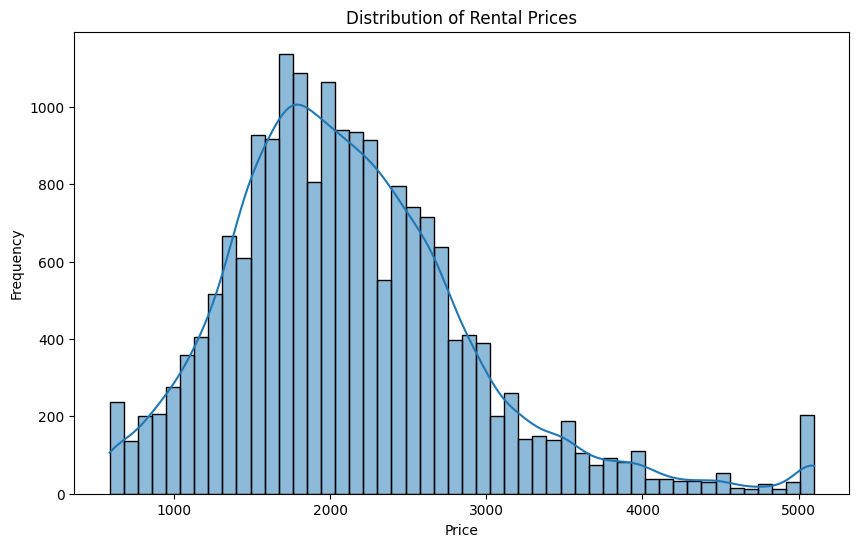

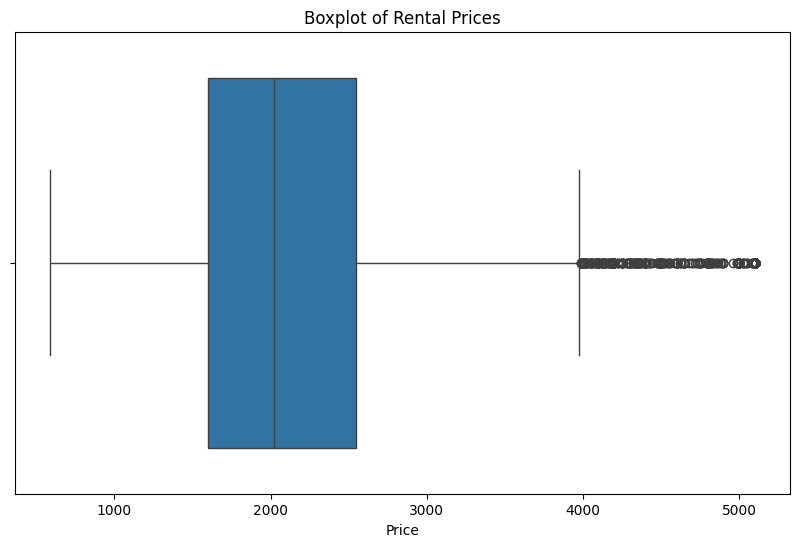

In [18]:
# 2. Visualize the rental price distributions

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='price', data=df)
plt.title('Boxplot of Rental Prices')
plt.xlabel('Price')
plt.show()

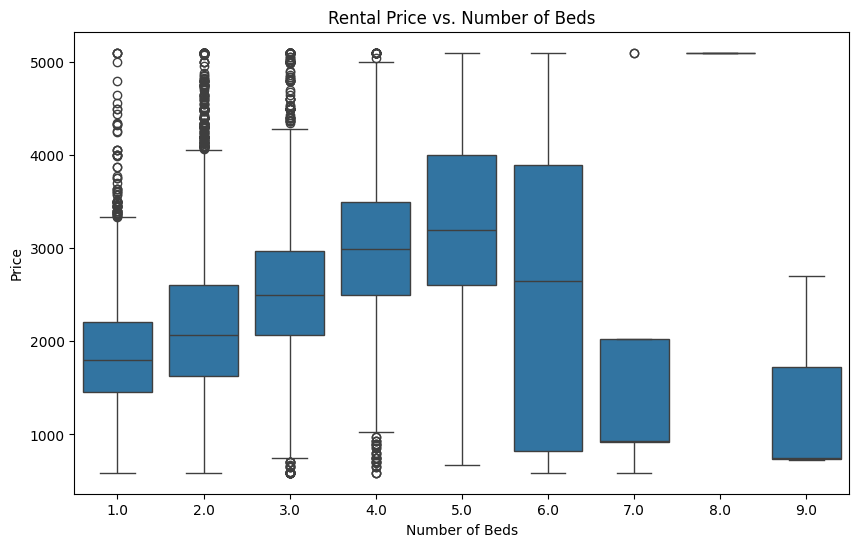

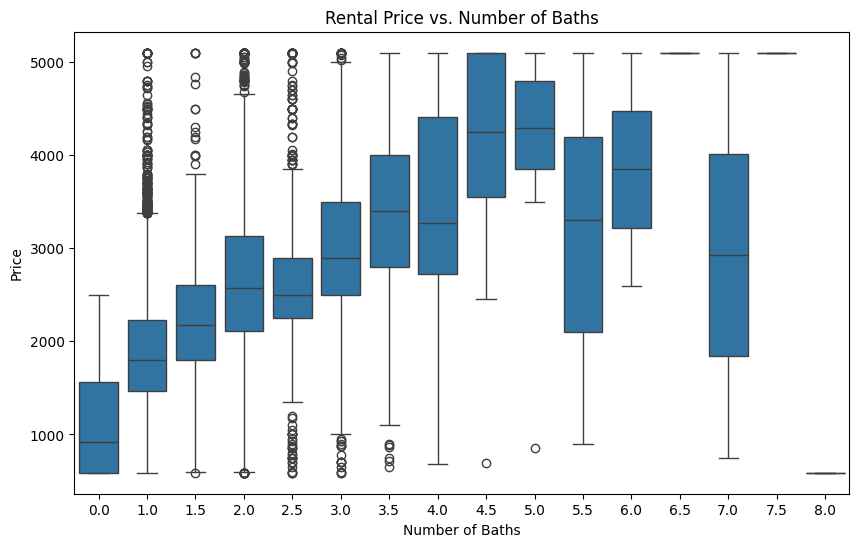

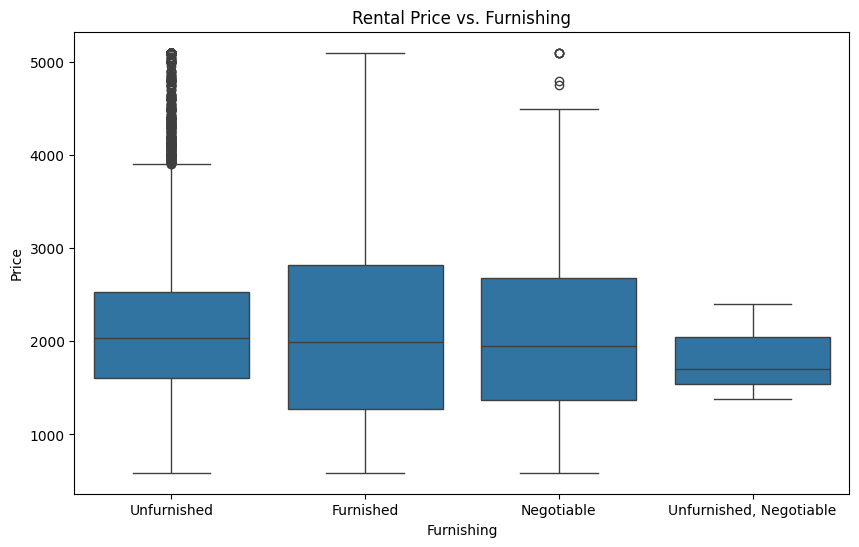

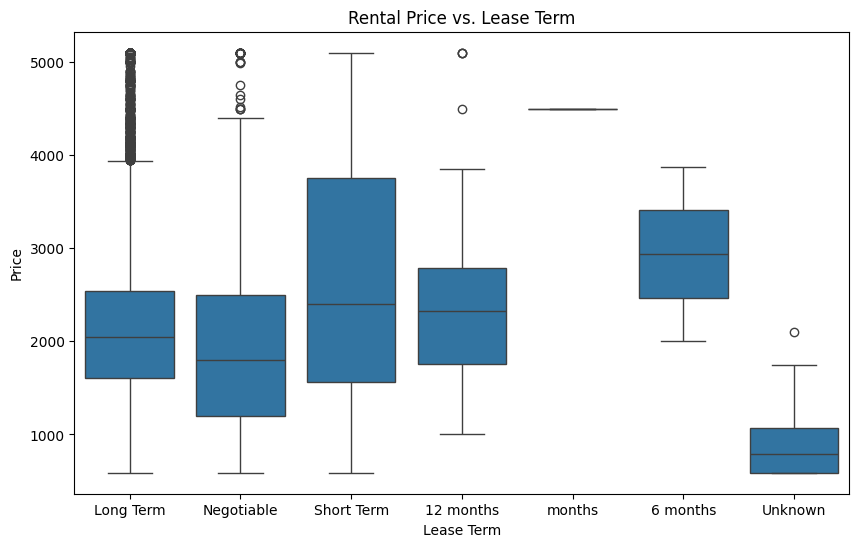

In [19]:
# 3. Price vs. Other Features

# Price vs. number of beds
plt.figure(figsize=(10, 6))
sns.boxplot(x='beds', y='price', data=df)
plt.title('Rental Price vs. Number of Beds')
plt.xlabel('Number of Beds')
plt.ylabel('Price')
plt.show()

# Price vs. number of baths
plt.figure(figsize=(10, 6))
sns.boxplot(x='baths', y='price', data=df)
plt.title('Rental Price vs. Number of Baths')
plt.xlabel('Number of Baths')
plt.ylabel('Price')
plt.show()

# Price vs. furnishing
plt.figure(figsize=(10, 6))
sns.boxplot(x='furnishing', y='price', data=df)
plt.title('Rental Price vs. Furnishing')
plt.xlabel('Furnishing')
plt.ylabel('Price')
plt.show()

# Price vs. lease term
plt.figure(figsize=(10, 6))
sns.boxplot(x='lease_term', y='price', data=df)
plt.title('Rental Price vs. Lease Term')
plt.xlabel('Lease Term')
plt.ylabel('Price')
plt.show()

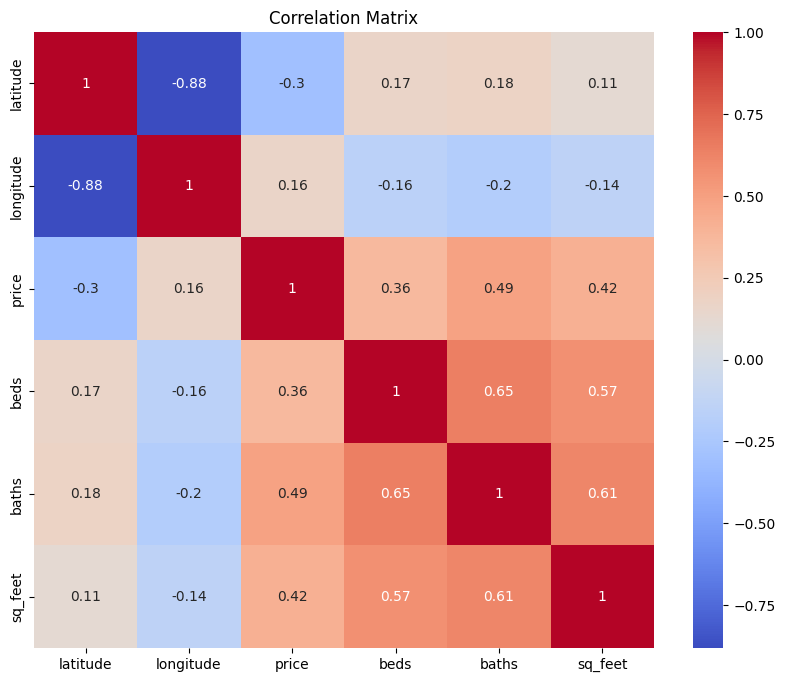

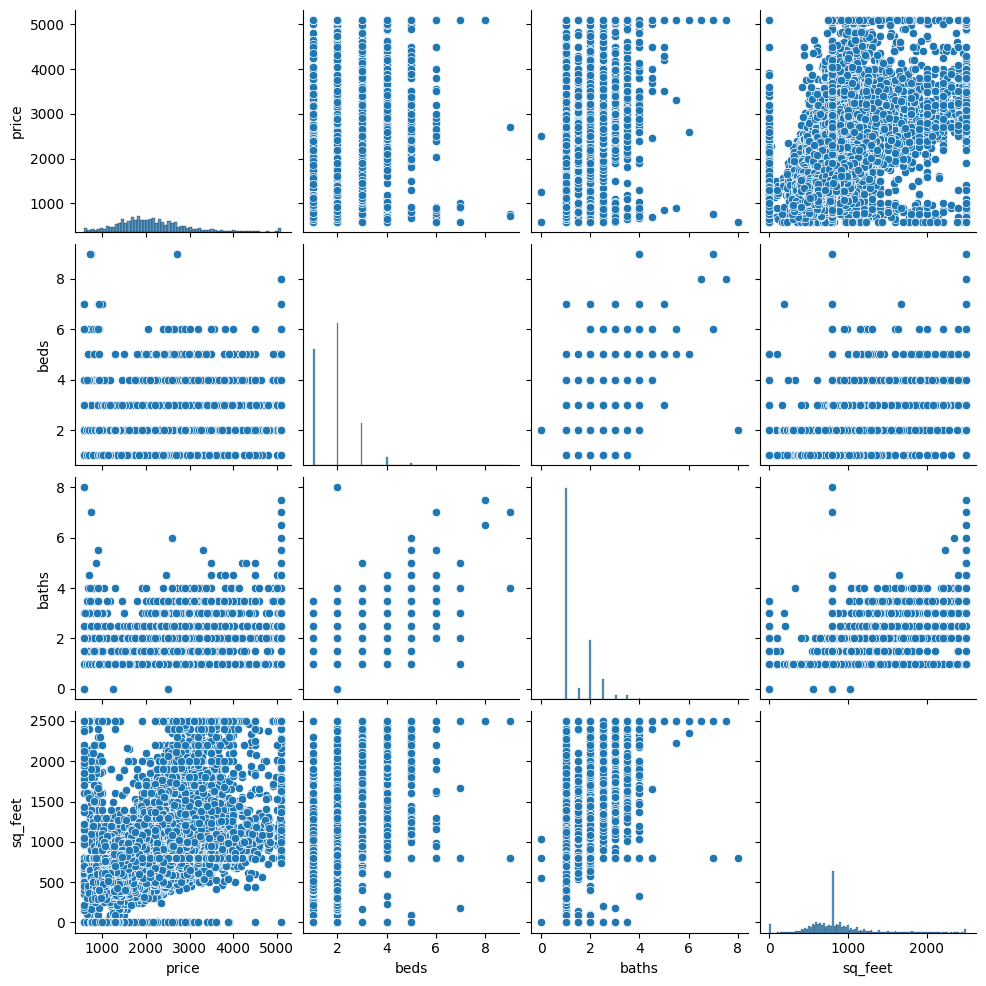

In [20]:
# 4. Correlation and Pairplot

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[float, int])

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot for numerical features
sns.pairplot(df[['price', 'beds', 'baths', 'sq_feet']])
plt.show()

# 5. Feature Engineering and Transformation

In [22]:
# 1. Feature creation

# Total rooms (beds + baths)
df['total_rooms'] = df['beds'] + df['baths']

# Price per square foot (avoid division by zero)
df['price_per_sqft'] = df['price'] / df['sq_feet'].replace(0, np.nan)

# Extract year, month, and day from availability date
df['availability_year'] = df['availability_date'].dt.year
df['availability_month'] = df['availability_date'].dt.month
df['availability_day'] = df['availability_date'].dt.day

In [23]:
# 2. Handling categorical data

# Identify categorical columns
categorical_cols = ['city', 'province', 'lease_term', 'type', 'furnishing', 'smoking']

# One-hot encode categorical columns into format to provide to ML algorithms
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [24]:
# 3. Feature scaling

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Fill NaN values in numeric columns with the mean of each column
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# For non-numeric columns, fill with mode of each column
for col in non_numeric_cols:
    df[col].fillna(df[col].mode()[0], inplace=True) 

# Identify numerical columns
numerical_cols = ['latitude', 'longitude', 'price', 'beds', 'baths', 'sq_feet', 'total_rooms', 'price_per_sqft']

# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Drop the original 'availability_date' since useful features have been extracted from it
df = df.drop(columns=['availability_date'])

# Check the dataframe after feature engineering
print(df.head())

  rentfaster_id           address  latitude  longitude     price      beds  \
0        468622  69 Gateway Dr NE  0.748108  -0.889048  0.453138  0.182346   
1        468622  69 Gateway Dr NE  0.748108  -0.889048  0.703315  1.374418   
2        468622  69 Gateway Dr NE  0.748108  -0.889048  0.202962  0.182346   
3        468622  69 Gateway Dr NE  0.748108  -0.889048 -0.047215  0.182346   
6        468622  69 Gateway Dr NE  0.748108  -0.889048  0.453138  0.182346   

      baths   sq_feet                                               link  \
0  1.791087  1.434011  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
1  1.791087  1.673056  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
2  1.791087  0.860815  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
3  1.791087  1.434011  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   
6  1.791087  1.300351  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...   

   cats  ...  type_Storage  type_Townhouse  type_Vacation Home  \
0  True 

In [25]:
# 4. Save the prepared data for modeling

df.to_csv('prepared_data.csv', index=False)

# 5. Model Comparison

In [27]:
# 1. Prepare the features and target variable

X = df[['latitude', 'longitude', 'beds', 'baths', 'sq_feet', 'price_per_sqft', 
        'type_Storage', 'type_Townhouse', 'type_Vacation Home', 
        'furnishing_Negotiable', 'furnishing_Unfurnished', 
        'furnishing_Unfurnished, Negotiable', 'smoking_Non-Smoking', 
        'smoking_Smoke Free Building', 'smoking_Smoking Allowed', 
        'smoking_Unknown']]

y = df['price']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# 2. Build the models

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest Regressor': RandomForestRegressor()
}

# Train the models
for name, model in models.items():
    model.fit(X_train, y_train)

# 6. Choose a Validation Scheme

In [31]:
# 1. Evaluate each model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

for name, model in models.items():
    mse, mae, r2 = evaluate_model(model, X_test, y_test)
    print(f"{name} - Mean Squared Error: {mse:.4f}")
    print(f"{name} - Mean Absolute Error: {mae:.4f}")
    print(f"{name} - R-squared: {r2:.4f}")
    print()

Linear Regression - Mean Squared Error: 0.5434
Linear Regression - Mean Absolute Error: 0.5216
Linear Regression - R-squared: 0.4660

Ridge Regression - Mean Squared Error: 0.5434
Ridge Regression - Mean Absolute Error: 0.5216
Ridge Regression - R-squared: 0.4661

Random Forest Regressor - Mean Squared Error: 0.0140
Random Forest Regressor - Mean Absolute Error: 0.0260
Random Forest Regressor - R-squared: 0.9862



In [32]:
# 2. Select the best model

best_model_name = min(models.keys(), key=lambda name: evaluate_model(models[name], X_test, y_test)[0])
best_model = models[best_model_name]

print(f"Best Performance: {best_model_name}")
print (" - lowest MSE and MAE")
print (" - highest R-squared value")

Best Performance: Random Forest Regressor
 - lowest MSE and MAE
 - highest R-squared value


# 7. Make Predictions with the Final Model

In [34]:
# 1. Generate predictions using the best model on the training data

training_predictions = best_model.predict(X_train)

# Evaluate predictions on the training data
mse_train = mean_squared_error(y_train, training_predictions)
mae_train = mean_absolute_error(y_train, training_predictions)
r2_train = r2_score(y_train, training_predictions)

print(f"Training Data - Mean Squared Error: {mse_train:.4f}")
print(f"Training Data - Mean Absolute Error: {mae_train:.4f}")
print(f"Training Data - R-squared: {r2_train:.4f}")

Training Data - Mean Squared Error: 0.0023
Training Data - Mean Absolute Error: 0.0111
Training Data - R-squared: 0.9976


In [35]:
# 2. Generate predictions on the test data with the best model

test_predictions = best_model.predict(X_test)

# Evaluate predictions on the test data
mse_test = mean_squared_error(y_test, test_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)
r2_test = r2_score(y_test, test_predictions)

print(f"Test Data - Mean Squared Error: {mse_test:.4f}")
print(f"Test Data - Mean Absolute Error: {mae_test:.4f}")
print(f"Test Data - R-squared: {r2_test:.4f}")

Test Data - Mean Squared Error: 0.0140
Test Data - Mean Absolute Error: 0.0260
Test Data - R-squared: 0.9862


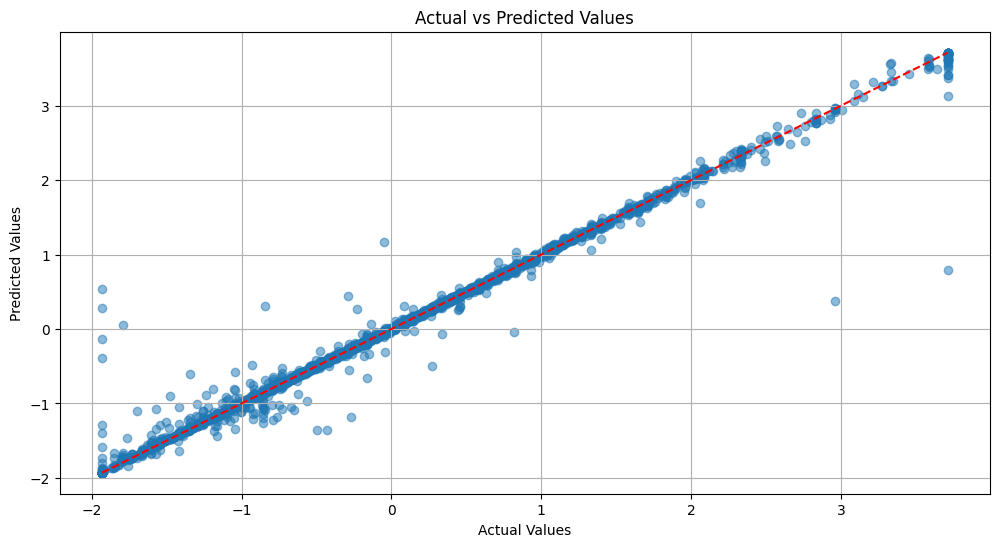

In [36]:
# 3. Visualize Predictions vs Actual Values

plt.figure(figsize=(12, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
# Ideal line '--'
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.savefig('predicted_vs_actual.png') 
plt.show()

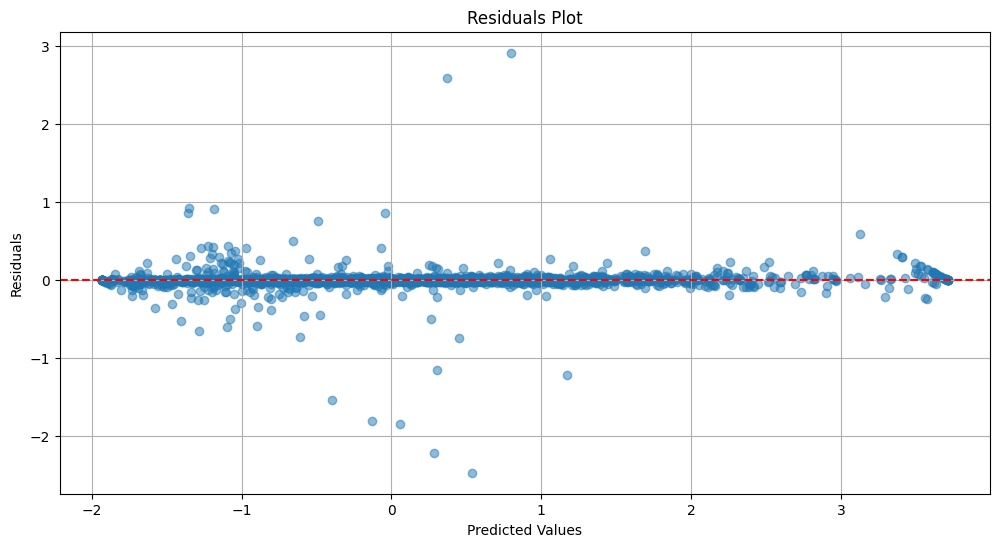

In [37]:
# 4. Visualize Residuals

residuals = y_test - test_predictions
plt.figure(figsize=(12, 6))
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.savefig('residuals_plot.png') 
plt.show()

In [38]:
# 5. Save the prepared data for modeling

df.to_csv('new_data_predictions.csv', index=False)